# 📈 Inflation Predictor

A data science project focused on predicting inflation rates using historical data from the World Bank. This notebook contains code and documentation for the full machine learning pipeline, from data acquisition and preprocessing to model deployment via Streamlit.

### Disclaimer
This streamlit web app does not depcict truth, It is only a functional tool into which real world data can be inputed, and used to derive insight.

### 🔬 Key Processes:

1. **Data Collection** – Fetching datasets from the World Bank API or CSV files.
2. **Data Cleaning** – Handling missing values, formatting inconsistencies, and outliers.
3. **Exploratory Data Analysis** – Understanding distributions, trends, and correlations.
4. **Feature Engineering** – Generating relevant features such as lag variables, rolling averages, and economic ratios.
5. **Model Training** – Training and tuning the XGBoost model using scikit-learn pipelines.
6. **Evaluation** – Measuring performance using RMSE, MAE, and R².
7. **Visualization** – Presenting insights and predictions in a user-friendly format.
8. **Deployment** – Deploying the predictive model using Streamlit.

Import the Key Libraries used in the data workflow.

In [3]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd 
import numpy as np 
import streamlit as st 
import xgboost as xgb

Load the data.
This data is a csv file from the world bank showing all the inflation rates from 1960 to 2023.

In [4]:
# Step 1: Load the data
my_data = r"/Users/d/Desktop/world_inflation_data/Sheet 1-API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_122376.csv"
df = pd.read_csv(my_data, skiprows = 4)

Now, because of the shape of the data, we'd have to melt it, such that pandas can easily interpret it.
We are trying to minimise errors.

In [5]:
# Step 2: Reshape / melt the wide format into long format
df_long = df.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Inflation"
)

Step 3: Clean the Year column

df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")

What’s happening here?
df_long["Year"]:  This selects the Year column from our DataFrame df_long.

At this stage, the Year column might not be in a clean numeric format. For example, it could contain values like:
"1990", "1991", "N/A", "Year 1992", "missing"
pd.to_numeric(..., errors="coerce"):
This function tries to convert values to numbers.
If a value can be converted (e.g. "1990" → 1990), it becomes a number.
If a value cannot be converted (e.g. "N/A" or "Year 1992"), then:
With errors="coerce", it replaces the value with NaN (Not a Number).
The result is assigned back to df_long["Year"], so now the entire column will contain clean numeric year values or NaN where conversion failed.

In [6]:
# Step 3: Clean the Year column
df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")

Step 4.
Here we are going to deal will mising values.
To try to manage biasness, I will fill the empty cells with the median value of the entire column per column.

In [7]:
# Step 4: Handle missing values → fill with median
df_long["Inflation"] = df_long["Inflation"].fillna(df_long["Inflation"].median())

### Step 5: Create Lagged Features

When working with **time series data**, past values often influence future outcomes.  
To capture these temporal dependencies, we can create **lagged features** — new variables that represent the value of a feature from previous time periods.

In this case, we are focusing on **inflation rates** across different countries and years.

1. **Sort the data**  
   First, the dataset is sorted by `Country Name` and `Year` to ensure the temporal order is correct.

2. **Create lagged features**  
   - `inflation_lag1`: The inflation rate from **1 year before** (previous year).  
   - `inflation_lag4`: The inflation rate from **4 years before**.  

This helps the model learn from historical inflation trends when predicting future values.

In [9]:
# Step 5: Create lagged features
df_long = df_long.sort_values(["Country Name", "Year"])
df_long["inflation_lag1"] = df_long.groupby("Country Name")["Inflation"].shift(1)
df_long["inflation_lag4"] = df_long.groupby("Country Name")["Inflation"].shift(4)

# Fill lagged missing with median too
df_long["inflation_lag1"] = df_long["inflation_lag1"].fillna(df_long["inflation_lag1"].median())
df_long["inflation_lag4"] = df_long["inflation_lag4"].fillna(df_long["inflation_lag4"].median())

### Step 6: Define Features and Target

Now that we have engineered **lagged inflation features**, we need to specify:  

1. **Features (X)**  
   - These are the input variables used to make predictions.  
   - In our case:  
     - `inflation_lag1`: Inflation from the previous year.  
     - `inflation_lag4`: Inflation from 4 years prior.  

2. **Target (y)**  
   - This is the variable we want to predict.  
   - Here, the target is the **current inflation rate** (`"Inflation"`).

---

### Train-Test Split

To evaluate how well our model performs, we split the dataset into:  
- **Training set** (75% of the data): Used to train the model.  
- **Test set** (25% of the data): Used to evaluate model performance on unseen data.  

⚠️ Notice that `shuffle=False` is set.  
- This is important for **time series data**, because shuffling would mix up chronological order.  
- By keeping the time order intact, the model simulates real-world forecasting (predicting the future from the past).

---


In [10]:
# Step 6: Define features and target
features = ["inflation_lag1", "inflation_lag4"]
X = df_long[features]
y = df_long["Inflation"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = 0.25)

### Step 7: Train the Model

With our dataset prepared, we can now train a machine learning model to predict inflation.  

#### 1. Model Choice
We are using **XGBoost Regressor (`XGBRegressor`)**:
- A powerful **gradient boosting algorithm** designed for speed and performance.  
- Well-suited for structured/tabular data, such as inflation time series.  
- The `objective="reg:squarederror"` setting specifies that this is a **regression problem** (predicting continuous values).

#### 2. Model Training
- The model is trained on the **training set (`X_train`, `y_train`)**.  
- It learns the relationship between past inflation values (lags) and the current inflation rate.  

#### 3. Prediction and Evaluation
- After training, the model makes predictions (`y_pred`) on the **test set (`X_test`)**.  
- We then evaluate performance using **Mean Absolute Error (MAE)**:
  - Measures the average absolute difference between predicted and actual values.  
  - Lower MAE = better predictive performance.  

---


In [11]:
# Step 7: Train model
model = xgb.XGBRegressor(objective = "reg:squarederror")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))

MAE: 8.934512998051018


### Step 8: Visualization

Before interpreting the model results, it’s useful to **visualize the raw inflation data** over time.  
This helps us understand the general trend, periodicity, and fluctuations in the data.

#### Plot Details
- **Line plot** of `Inflation` against `Year` for all countries.  
- A **marker ("o")** is added to highlight actual data points.  
- **X-axis ticks** are shown every 5 years for readability.  
- Labels and titles are included for clarity.

This visualization provides important context:  
- Do inflation rates show smooth trends or sharp spikes?  
- Are there country-specific patterns or global cycles?  
- How might past values (lags) influence future values?

---


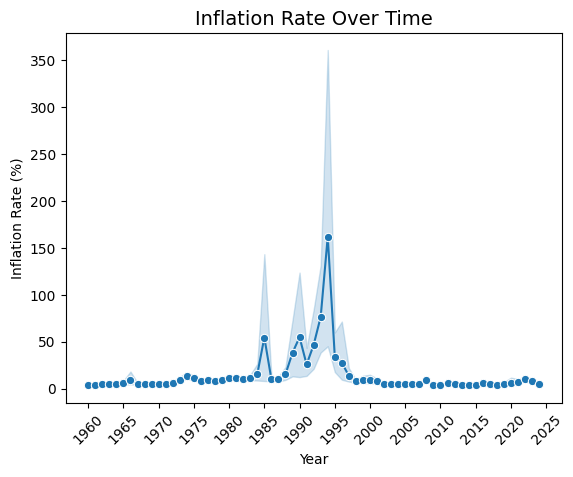

In [12]:
# Step 8: Visualisation
sns.lineplot(x="Year", y="Inflation", data=df_long, marker="o")
plt.title("Inflation Rate Over Time", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Inflation Rate (%)")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))  # show every 5 years
plt.xticks(rotation=45)
plt.show()

### Step 9: Streamlit App – Interactive Inflation Forecasting Tool

To make the forecasting model more practical, we build an **interactive web application** using **Streamlit**.  
This allows users (e.g., policymakers, analysts) to **select a country** and test how past inflation dynamics might project into future forecasts.

---

#### 🔹 Key Components of the App

1. **Title and Layout**
   - The app is titled *"Inflation Forecasting Tool"*.
   - A **sidebar** is used for user inputs (country selection and policy-related variables).

2. **Country Selection**
   - Dropdown menu with all available countries from the dataset.
   - Filters the dataset to only the selected country for focused forecasting.

3. **User Inputs (Policy Simulation)**
   - Users can input hypothetical policy and economic variables:  
     - Quarter of prediction  
     - Monetary Policy Rate (%)  
     - Exchange Rate (local currency / USD)  
     - Global Oil Price (USD/barrel)  
     - Food Price Index  
     - Money Supply Growth (%)  
   - **Note**: These inputs are **not yet part of the dataset**; they are placeholders for future model improvements.

4. **Action Button**
   - When the user clicks **"Run Forecast"**, the app:  
     - Checks if enough historical data exists.  
     - Trains a new XGBoost model on the **selected country’s data only**.  
     - Generates a forecast based on the most recent lagged values (`inflation_lag1`, `inflation_lag4`).  

5. **Output**
   - Displays the predicted inflation rate for the chosen country.  
   - Shows a **line chart** of historical inflation rates for visualization.

---

In [13]:
# Step 9: Streamlit App
st.title("Inflation Forecasting Tool")

# Country selection (dropdown)
countries = df_long["Country Name"].unique()
selected_country = st.sidebar.selectbox("Select Country", sorted(countries))

# Filter dataset for chosen country
country_data = df_long[df_long["Country Name"] == selected_country].copy()

# User inputs
st.sidebar.header("Policy Inputs (not in dataset, for simulation only)")
quarter = st.sidebar.selectbox("Quarter", [1, 2, 3, 4])
policy_rate = st.sidebar.number_input("Monetary Policy Rate (%)", 0.00, 25.00, 10.00, step=0.01, format="%.2f")
exchange_rate = st.sidebar.number_input("Exchange Rate (Country Currency/USD)", 3000, 6000, 3700)
oil_price = st.sidebar.number_input("Global Oil Price (USD/barrel)", 20, 200, 80)
food_index = st.sidebar.number_input("Food Price Index", 50, 200, 120)
m2_growth = st.sidebar.number_input("Money Supply Growth (%)", -10, 30, 10)

# Action button
if st.button("Run Forecast"):
    if country_data.shape[0] < 5:
        st.warning("Not enough data to generate forecast for this country.")
    else:
        # Train model only on selected country’s data
        features = ["inflation_lag1", "inflation_lag4"]
        X = country_data[features]
        y = country_data["Inflation"]

        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
        model = xgb.XGBRegressor(objective="reg:squarederror")
        model.fit(X_train, y_train)

        latest_data = country_data.tail(1)
        X_future = latest_data[["inflation_lag1", "inflation_lag4"]]
        prediction = model.predict(X_future)[0]

        st.success(f"Predicted Inflation for {selected_country} (Quarterly %): {prediction:.4f}")

        # Show chart of actual inflation
        st.line_chart(country_data.set_index("Year")["Inflation"])

2025-08-29 12:09:17.153 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-29 12:09:17.382 
  command:

    streamlit run /Users/d/Library/Python/3.12/lib/python/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-08-29 12:09:17.383 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-29 12:09:17.384 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-29 12:09:17.386 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-29 12:09:17.387 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-29 12:09:17.388 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-29 12:09:17.389 Thread 'Main

### Step 10: Prediction Using Lag Features

In this step, we generate a **forecast of inflation** using only the **lag features** created earlier.  
This represents a **baseline forecasting approach** where predictions rely exclusively on past inflation values (no external policy or macroeconomic inputs yet).

---

#### 🔹 Process

1. **Select the latest data point**  
   - We take the most recent row (`tail(1)`) from the dataset.  
   - This contains the latest available lag values (`inflation_lag1` and `inflation_lag4`).

2. **Prepare future input**  
   - Extract lagged features as `X_future`.  
   - Feed these into the trained model to generate a forecast.

3. **Display prediction**  
   - Use `st.metric` to display the predicted inflation in a **dashboard-style widget**.  
   - The forecast is shown as a quarterly percentage.

4. **Visualization**  
   - A line chart of historical inflation is included to provide context for the prediction.

---

In [14]:
# Prediction uses only lag features from dataset
latest_data = df_long.tail(1)
X_future = latest_data[["inflation_lag1", "inflation_lag4"]]
prediction = model.predict(X_future)[0]

st.metric("Predicted Inflation (Quarterly %)", f"{prediction:.2f}")

# Show chart
st.line_chart(df_long[["Year", "Inflation"]].set_index("Year"))

2025-08-29 12:10:35.239 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-29 12:10:35.240 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-29 12:10:35.241 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-29 12:10:37.798 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-29 12:10:37.799 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-29 12:10:37.800 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()